#### Creating a Machine Learning Model to predcit the event based on Φ-OTDR readings

We import the required libraries wherever and whenever required as per usage

In [1]:
import pandas as pd
df = pd.read_csv("images2.csv", names=["file_path","target"])
print(df.describe)


<bound method NDFrame.describe of                           file_path  target
0        ../trainData/drop/5491.jpg       0
1        ../trainData/drop/2712.jpg       0
2        ../trainData/drop/1075.jpg       0
3        ../trainData/drop/1237.jpg       0
4        ../trainData/drop/2854.jpg       0
...                             ...     ...
20995  ../trainData/qiaoji/2754.jpg       4
20996  ../trainData/qiaoji/3925.jpg       4
20997  ../trainData/qiaoji/4501.jpg       4
20998   ../trainData/qiaoji/252.jpg       4
20999  ../trainData/qiaoji/2526.jpg       4

[21000 rows x 2 columns]>


In [2]:
import numpy as np
from PIL import Image
from PIL import ImageFilter

from skimage.filters import prewitt_h,prewitt_v

Extracting basic features such as mean, std, corr and zero crossings

In [3]:
def img_mean(npa):  return np.mean(npa)

def img_std(npa):   return np.std(npa)

def img_corr(image):
    img_med = image.filter(ImageFilter.MedianFilter(size = 3))
    return np.corrcoef(image,img_med).mean()

def img_zcrs(npa):
    zcr = np.mean(npa, axis = 0) - npa.mean().mean()
    zero_crossings = np.where(np.diff(np.signbit(zcr)))[0]
    return len(zero_crossings)

def img_skew(npa):  return pd.DataFrame(npa).skew().mean()

def img_kurt(npa):  return pd.DataFrame(npa).kurtosis().mean()

Extracting the features such as number of data points in certain frequency ranges

In [4]:
def freq_ranges(npa):
    col = np.mean(npa, axis = 0)
    bt_0_50 = ((50>col) & (col>=0)).sum()
    bt_50_100 = ((100>col) & (col>=50)).sum()
    bt_100_150 = ((150>col) & (col>=100)).sum()
    ab_150 = (col>=150).sum()
    return bt_0_50, bt_50_100, bt_100_150, ab_150

def stren(npa): 
    temperory=freq_ranges(npa)
    strn=temperory[2]+temperory[3]
    return strn
    
def event(npa):
    zcr = np.mean(npa, axis = 0) - 100
    ev = len(np.where(np.diff(np.signbit(zcr)))[0])
    return ev

def img_stren(npa):

    if event(npa)==0:
        return 0
    else:
        val=2*stren(npa)/event(npa)
        return val

def spectral_energy(npa):
  mat=npa
  total=npa.sum()
  x=[]
  for i in range(4):
    count=0
    for j in range((len(mat)//4)*i,(len(mat)//4)*(i+1)):
      count+=sum(mat[j])
    x.append(count/total)
  return x[0],x[1],x[2],x[3]

Overall Extraction of features from the Images

In [5]:
dfm = pd.DataFrame( columns = ["mean", "std", "corr", "zcrs"] )

temp_df = pd.DataFrame( columns = ["skew", "kurtosis", "event_strength"] )

se_df = pd.DataFrame( columns = ["x[0]", "x[1]", "x[2]", "x[3]" ])

for imgs in df.file_path:
    image = Image.open(imgs)
    npa = np.array(image)
    
    dfm.loc[len(dfm)] = [ img_mean(npa), img_std(npa),img_corr(image), img_zcrs(npa) ]
    temp_df.loc[len(temp_df)] = [ img_skew(npa), img_kurt(npa), img_stren(npa)]
    list = spectral_energy(npa)
    se_df.loc[len(se_df)] = list

dfm = pd.concat([dfm, temp_df], axis=1)
dfm = pd.concat([dfm, se_df], axis=1)
dfm['target'] = df.target
dfm

,mean,std,corr,zcrs,skew,kurtosis,event_strength,x[0],x[1],x[2],x[3],target
0,25.765820,37.987719,0.641946,38.0,1.693545,4.235893,6.000000,0.123381,0.288142,0.289867,0.298609,0
1,24.484570,40.607841,0.704699,18.0,1.683911,4.448071,4.000000,0.124027,0.312687,0.314106,0.249180,0
2,25.393633,38.616103,0.636090,26.0,1.581144,3.511482,4.500000,0.109798,0.266535,0.300964,0.322703,0
3,38.179883,52.298636,0.582311,36.0,1.662758,4.098637,5.142857,0.093242,0.236650,0.300809,0.369299,0
4,32.750898,47.866475,0.686309,24.0,1.601055,4.052781,3.000000,0.118435,0.258129,0.284491,0.338945,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20995,41.145313,49.929015,0.486868,36.0,1.436900,2.693499,2.857143,0.094429,0.239033,0.285022,0.381517,4
20996,22.244258,40.136412,0.669736,10.0,1.632976,3.840018,2.000000,0.141502,0.277087,0.334228,0.247183,4
20997,23.887070,32.084761,0.480300,18.0,1.674582,4.021697,1.200000,0.115755,0.269571,0.313459,0.301216,4
20998,24.216875,36.220532,0.556774,6.0,1.662630,4.064199,2.500000,0.120955,0.290392,0.315316,0.273337,4


PLOTTING THE BOXPLOTS

dfm.boxplot(column='mean', by = 'target')
dfm.boxplot(column='std', by = 'target')
dfm.boxplot(column='corr', by = 'target')
dfm.boxplot(column='zcrs', by = 'target')
dfm.boxplot(column='x[0]', by = 'target')
dfm.boxplot(column='x[1]', by = 'target')
dfm.boxplot(column='x[2]', by = 'target')
dfm.boxplot(column='x[3]', by = 'target')
dfm.boxplot(column='skew', by = 'target')
dfm.boxplot(column='kurtosis', by = 'target')
dfm.boxplot(column='event_strength', by = 'target')

We split the dataframe into the required features and target to train the model

In [6]:
X = dfm.drop('target',axis='columns')
y = dfm.target

from sklearn.preprocessing we import StandardScaler to remove the mean and scales each feature/variable to unit variance


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.20061701,  0.10082043,  1.44455375, ...,  0.44499414,
        -0.44067398, -0.18257587],
       [-0.28937809,  0.26485498,  1.84970224, ...,  0.99050104,
         0.39962908, -0.74755305],
       [-0.22640102,  0.14016085,  1.40674595, ..., -0.0352248 ,
        -0.05596038,  0.09282124],
       ...,
       [-0.33077106, -0.26873829,  0.40092621, ...,  0.03225498,
         0.37721028, -0.15278363],
       [-0.3079232 , -0.00981549,  0.89466378, ...,  0.49499257,
         0.44160167, -0.47143098],
       [ 1.63031299,  1.34855951, -0.34311493, ..., -1.00232305,
        -0.72361861,  0.99350207]])

In [8]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.title = 'ML Model Scores with different splits'
tab.field_names = ['Split Ratio', 'RandomForestClassifier']

We use train_test_split to split the data for training the model and for testing the model,\
we can give paramaters such as test_size to determine how much of the data is given to testing and training, \
then import the required model from respective library and create a model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

splits = [0.1]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = split, random_state = 40)

    model_rfc = RandomForestClassifier(n_estimators=800)
    model_rfc.fit(X_train, y_train)
    #rfcscore = model_rfc.score(X_test, y_test)
    scoresrfc = cross_val_score(RandomForestClassifier(), X_test, y_test, cv=5)
    scoresrfc = scoresrfc.mean()

    tab.add_row([f"Split: {split}", scoresrfc])

In [10]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Printing all the scores of the Models

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\yadap\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

N_EST = []
for i in range(100,500):
    N_EST.append(i)

In [12]:
rf_random.cv_results_

{'mean_fit_time': array([ 27.07651703, 109.16229026,  92.3728145 , 226.25537936,
         85.55738433,  94.08864284, 132.45135307,  78.3161703 ,
        133.84673691, 172.02175816,  28.76424758, 104.1894908 ,
        189.88664532, 149.41322319,  99.20308812, 217.20094872,
         74.39464275,  78.97680473, 222.73949011,  47.69748791,
        230.63675451, 209.06380773, 106.99031536, 143.04056104,
        182.50952196,  51.04574982, 185.24397731,  77.85974646,
        240.52804152,  94.87939175, 142.78674014,  98.8872838 ,
        101.66629807,  61.22625907, 136.83316016,  97.37991238,
         96.57455508,  64.97621298,  62.46671478,  82.37143222,
         12.79381784,  45.24341091,  59.47718692,  30.93639223,
         27.33684381,  79.65773241, 152.95703554,  48.27636512,
        136.54310155,  69.08228779, 211.27748497, 225.67478291,
        107.86379862, 109.86698794, 162.60583727,  64.48510456,
         91.71010168, 142.18413726, 111.42594504, 110.14843782,
         17.41250769,  

In [13]:
dftest = pd.DataFrame(rf_random.cv_results_)
dftest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,27.076517,0.566617,0.889320,0.033094,400,5,1,sqrt,30,True,"{'n_estimators': 400, 'min_samples_split': 5, ...",0.819048,0.821270,0.827143,0.822487,0.003415,41
1,109.162290,3.659890,5.075732,0.129422,2000,5,1,sqrt,10,True,"{'n_estimators': 2000, 'min_samples_split': 5,...",0.797143,0.802222,0.809524,0.802963,0.005082,90
2,92.372814,1.287405,2.186731,0.136100,1200,5,2,sqrt,10,False,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.798254,0.800952,0.809683,0.802963,0.004877,90
3,226.255379,2.720322,8.221787,0.089820,2000,2,4,auto,30,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.814286,0.822540,0.825397,0.820741,0.004711,68
4,85.557384,0.533274,4.325910,0.181233,1600,2,4,sqrt,10,True,"{'n_estimators': 1600, 'min_samples_split': 2,...",0.794921,0.799524,0.807302,0.800582,0.005110,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,43.195366,0.331404,0.902618,0.005955,400,10,2,auto,40,False,"{'n_estimators': 400, 'min_samples_split': 10,...",0.816349,0.822540,0.827143,0.822011,0.004422,49
96,84.471623,0.675612,1.944905,0.036145,1000,2,1,auto,10,False,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.796825,0.802698,0.810952,0.803492,0.005795,88
97,21.867828,0.146838,0.456214,0.011569,200,5,4,auto,100,False,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.815238,0.822381,0.825873,0.821164,0.004426,63
98,122.946723,0.560182,3.492958,0.037858,2000,2,2,sqrt,20,True,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.818254,0.822381,0.827460,0.822698,0.003765,33


In [14]:
file_data='rf_0.1.csv'
dftest.to_csv(file_data)

In [15]:
rf_random.best_params_


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf','poly'), 'C':C}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train,y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C':C, 'kernel': ('rbf','poly')})
sorted(clf.cv_results_)

dftest = pd.DataFrame(clf.cv_results_)
dftest

In [16]:
#file_data='file_data_new.csv'
#dftest.to_csv(file_data)

In [17]:
print(tab)

+-----------------------------------------+
|  ML Model Scores with different splits  |
+--------------+--------------------------+
| Split Ratio  |  RandomForestClassifier  |
+--------------+--------------------------+
|  Split: 0.1  |    0.768095238095238     |
+--------------+--------------------------+


We use Seaborn library to plot the confusion matrix to check the truth matrix i.e, \
how many correct predictions are there and for how many the model was confused to predict

We use the last model to plot the confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

y_pred_rfc = model_rfc.predict(X_test)

cm_rfc = confusion_matrix(y_test, y_pred_rfc)


In [19]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_pred_rfc))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_rfc, digits=3))

[[327   8   0   1  74]
 [  6 298  63  20  16]
 [  0  40 372  19   4]
 [  1  26  25 369   4]
 [ 53  21   2   0 351]]
              precision    recall  f1-score   support

           0      0.845     0.798     0.821       410
           1      0.758     0.739     0.749       403
           2      0.805     0.855     0.829       435
           3      0.902     0.868     0.885       425
           4      0.782     0.822     0.801       427

    accuracy                          0.818      2100
   macro avg      0.818     0.816     0.817      2100
weighted avg      0.819     0.818     0.818      2100



Text(0.5, 1.0, 'RandomForestClassifier')

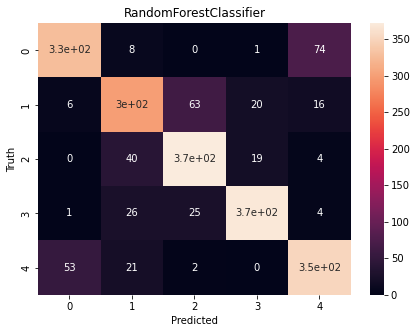

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(7,5))

sn.heatmap(cm_rfc, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('RandomForestClassifier')
